In [1]:
using Revise
using ReachabilityAnalysis, SparseArrays, Plots
#using BenchmarkTools
#using LaTeXStrings #, Latexify 
#using Plots, Plots.PlotMeasures

LazySets.set_rtol(Float64, 1e-14);
LazySets.set_ztol(Float64, 1e-14);

#using Polyhedra

In [1]:
using Revise, SX, ReachabilityAnalysis, Plots
using BenchmarkTools
LazySets.set_ztol(Float64, 1e-14)

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260


1.0e-14

In [11]:
file = "ARCH14-Platoon/Input_SpaceEx/platoon_continuous.xml"
H = readsxmodel(file, raw_dict=true) # ST=ConstrainedLinearControlContinuousSystem);
#@save "building.jld2" H

In [13]:
H["invariants"]

1-element Array{Array{Expr,1},1}:
 [:(-9 <= u <= 1)]

In [2]:
function platooning(;
                    deterministic_switching::Bool=true,
                    time_horizon::Float64=20.,
                    allowed_distance::Float64=50.)
    # three variables for each vehicle, (ei, d(et)/dt, ai) for
    # (spacing error, relative velocity, speed), and the last dimension is time
    n = 9 + 1

    # constants
    c1 = c2 = 5.   # clock constraints
    tb = 10.       # lower bound for loss of communication
    tc = tr = 20.  # upper bound for loss of communication (tc) and reset time (tr)

    # additional bloating to get a non-flat guard intersection
    guard_bloating = sqrt(eps(Float64))

    # transition graph
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 1, 2)

    # common inputs
    B = sparse([2, n], [1, 2], [1., 1.], n, 2)
    U = Hyperrectangle(low=[-9., 1.], high=[1., 1.])  # acceleration of the lead vehicle + time

    # mode 1 ("connected")
    A = zeros(n, n)
    for (i, j) in [(1, 2), (4, 5), (5, 3), (7, 8), (8, 6)]
        A[i, j] = 1.
    end
    for (i, j) in [(2, 3), (5, 6), (8, 9)]
        A[i, j] = -1.
    end
    A[3, :] = [1.6050, 4.8680, -3.5754, -0.8198, 0.4270, -0.0450, -0.1942,  0.3626, -0.0946, 0.]
    A[6, :] = [0.8718, 3.8140, -0.0754,  1.1936, 3.6258, -3.2396, -0.5950,  0.1294, -0.0796, 0.]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    invariant = deterministic_switching ?  HalfSpace(sparsevec([n], [1.], n), c1) :
        Universe(n)
    m_1 = @system(x' = Ax + Bu, x ∈ invariant, u ∈ U)

    # mode 2 ("not connected/connection broken")
    A = copy(A)
    A[3, 4:9] = zeros(6)
    A[6, 1:3] = A[6, 7:9] = zeros(3)
    invariant = deterministic_switching ?
        HalfSpace(sparsevec([n], [1.], n), c2) :
        Universe(n)
    m_2 = @system(x' = Ax + Bu, x ∈ invariant, u ∈ U)

    # modes
    modes = [m_1, m_2]

    # common reset
    reset = Dict(n => 0.)

    # transition l1 -> l2
    # (using a hyperplane in the deterministic case causes floating-point issues)
    guard = deterministic_switching ?
        HalfSpace(sparsevec([n], [-1.], n), -c1 + guard_bloating) :
        HPolyhedron([HalfSpace(sparsevec([n], [-1.], n), -tb),
                     HalfSpace(sparsevec([n], [1.], n), tc)])
    t1 = ConstrainedResetMap(n, guard, reset)

    # transition l2 -> l1
    guard = deterministic_switching ?
        HalfSpace(sparsevec([n], [-1.], n), -c2 + guard_bloating) :
        HalfSpace(sparsevec([n], [1.], n), tr)
    t2 = ConstrainedResetMap(n, guard, reset)

    # transition annotations
    resetmaps = [t1, t2]

    # switching
    H = HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])

    # initial condition in mode 1
    #X0 = Singleton(zeros(n))
    #X0 = zeros(n);
    X0 = BallInf(zeros(n), 0.0)
    initial_condition = [(1, X0)]

    #=
    system = InitialValueProblem(ℋ, initial_condition)

    # safety property
    d1 = zeros(n); d1[1] = -1.  # x1 >= -dmin
    d4 = zeros(n); d4[4] = -1.  # x4 >= -dmin
    d7 = zeros(n); d7[7] = -1.  # x7 >= -dmin
    property = Conjunction(
        [is_contained_in(HalfSpace(d, allowed_distance)) for d in [d1, d4, d7]])

    # default options
    options = Options(:T=>time_horizon, :property=>property)
    =#

    return IVP(H, initial_condition)
end

platooning (generic function with 1 method)

In [3]:
function platooning2(;
                    deterministic_switching::Bool=true,
                    time_horizon::Float64=20.,
                    allowed_distance::Float64=50.)
    # three variables for each vehicle, (ei, d(et)/dt, ai) for
    # (spacing error, relative velocity, speed), and the last dimension is time
    n = 9 + 1

    # constants
    c1 = c2 = 5.   # clock constraints
    tb = 10.       # lower bound for loss of communication
    tc = tr = 20.  # upper bound for loss of communication (tc) and reset time (tr)

    # additional bloating to get a non-flat guard intersection
    #guard_bloating = sqrt(eps(Float64))

    # transition graph
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 1, 2)

    # common inputs
    B = sparse([2, n], [1, 2], [1., 1.], n, 2)
    U = Hyperrectangle(low=[-9., 1.], high=[1., 1.])  # acceleration of the lead vehicle + time

    # mode 1 ("connected")
    A = zeros(n, n)
    for (i, j) in [(1, 2), (4, 5), (5, 3), (7, 8), (8, 6)]
        A[i, j] = 1.
    end
    for (i, j) in [(2, 3), (5, 6), (8, 9)]
        A[i, j] = -1.
    end
    A[3, :] = [1.6050, 4.8680, -3.5754, -0.8198, 0.4270, -0.0450, -0.1942,  0.3626, -0.0946, 0.]
    A[6, :] = [0.8718, 3.8140, -0.0754,  1.1936, 3.6258, -3.2396, -0.5950,  0.1294, -0.0796, 0.]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    invariant = deterministic_switching ?  HalfSpace(sparsevec([n], [1.], n), c1) : Universe(n)
    m_1 = @system(x' = Ax + Bu, x ∈ invariant, u ∈ U)

    # mode 2 ("not connected/connection broken")
    A = copy(A)
    A[3, 4:9] = zeros(6)
    A[6, 1:3] = A[6, 7:9] = zeros(3)
    invariant = deterministic_switching ?
        HalfSpace(sparsevec([n], [1.], n), c2) :
        Universe(n)
    m_2 = @system(x' = Ax + Bu, x ∈ invariant, u ∈ U)

    # modes
    modes = [m_1, m_2]

    # common reset
    reset = Dict(n => 0.)

    # transition l1 -> l2
    # (using a hyperplane in the deterministic case causes floating-point issues)
    guard = deterministic_switching ?
        Hyperplane(sparsevec([n], [1.], n), c1) :
        HPolyhedron([HalfSpace(sparsevec([n], [-1.], n), -tb),
                     HalfSpace(sparsevec([n], [1.], n), tc)])
    t1 = ConstrainedResetMap(n, guard, reset)

    # transition l2 -> l1
    guard = deterministic_switching ?
        Hyperplane(sparsevec([n], [1.], n), c2) :
        HalfSpace(sparsevec([n], [1.], n), tr)
    t2 = ConstrainedResetMap(n, guard, reset)

    resetmaps = [t1, t2]
    H = HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])
    X0 = BallInf(zeros(n), 0.0)
    initial_condition = [(1, X0)]
    return IVP(H, initial_condition)
end

platooning2 (generic function with 1 method)

In [3]:
GC.gc()
boxdirs = BoxDirections{Float64, Vector{Float64}}(10)
prob = platooning(; deterministic_switching=true, time_horizon=20., allowed_distance=42.);
#prob = platooning(; deterministic_switching=true, time_horizon=Inf, allowed_distance=50.)
sol = nothing
@time sol = solve(prob, alg=BOX(δ=0.01), #BFFPSV18(δ=0.01, vars=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dim=10),
                  clustering_method=LazyClustering(),
                  intersection_method=TemplateHullIntersection(boxdirs),
                  intersect_source_invariant=false,
                  intersect_source_invariant_method=TemplateHullIntersection(boxdirs),
                  tspan = (0.0 .. 20.));

  9.289164 seconds (21.13 M allocations: 1.033 GiB, 4.39% gc time)


In [4]:
#=
function ReachabilityAnalysis._overapproximate(B::BallInf, ::Type{<:HPolytope})
    H = overapproximate(B, Hyperrectangle)
    HPolytope([HalfSpace(Vector(c.a), c.b) for c in constraints_list(H)])
end

ReachabilityAnalysis.dim(c::ConstrainedResetMap) = c.dim

=#

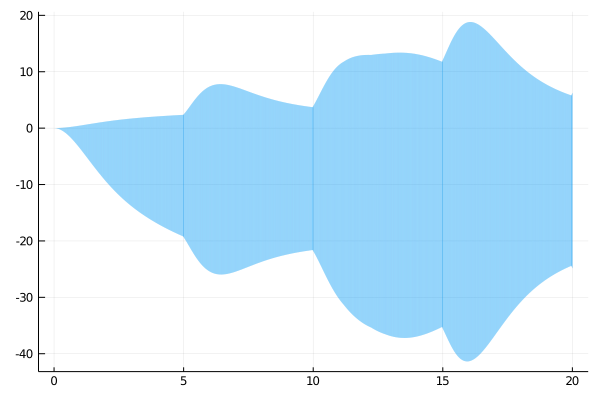

In [5]:
plot(sol, vars=(0, 1), lw=0.0)

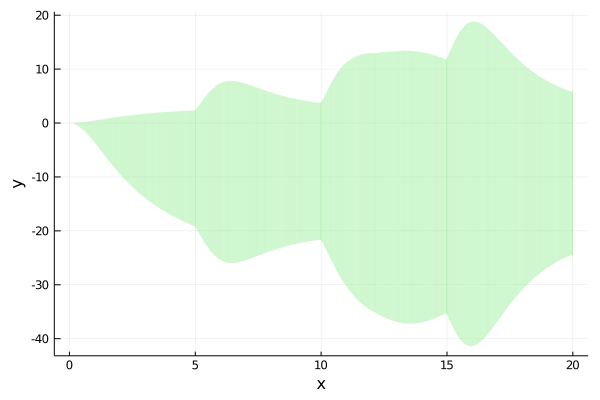

In [6]:
plot(sol, vars=(0, 1), lw=0.0, color=:lightgreen, xlab="x", ylab="y")

BNDxy Bounded time (no explicit bound on the number of transitions): 

For all t ∈ [0, 20] [s],

- x 1 (t) ≥ −d min [m], 
- x 4 (t) ≥ −d min [m], 
- x 7 (t) ≥ −d min [m], where d min =xy [m].

BND50: d min = 50.
BND42: d min = 42.
BND30: d min = 30

In [ ]:
 #BFFPSV18(δ=0.01, vars=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dim=10),

In [15]:
sol = nothing
GC.gc()

boxdirs = BoxDirections{Float64, Vector{Float64}}(10)
octdirs = CustomDirections([Vector(c) for c in OctDirections(10)])

dmin = 30.0
prob = platooning2(; deterministic_switching=true, time_horizon=20., allowed_distance=dmin)

#prob = platooning(; deterministic_switching=true, time_horizon=Inf, allowed_distance=50.)

@time sol = solve(prob, alg=BOX(δ=0.01),
                  clustering_method=LazyClustering(10),
                  intersection_method=TemplateHullIntersection(octdirs),
                  intersect_source_invariant=false,
                  intersect_source_invariant_method=TemplateHullIntersection(boxdirs),
                  tspan = (0.0 .. 20.));

  1.017840 seconds (2.40 M allocations: 350.551 MiB, 2.92% gc time)


In [16]:
@show ρ(sparsevec([1], [-1.0], 10), sol)

ρ(sparsevec([1], [-1.0], 10), sol) = 41.36589455260286


41.36589455260286

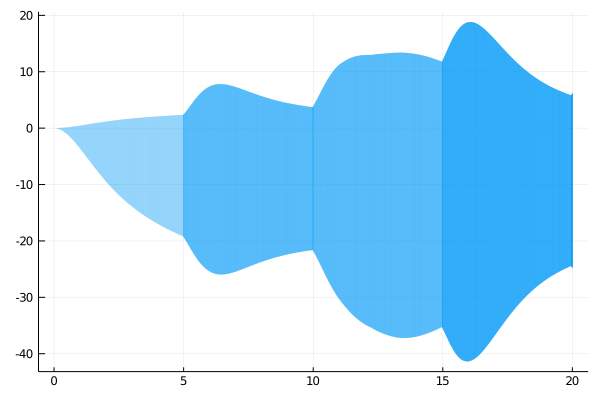

In [17]:
plot(sol, vars=(0, 1), lw=0.0)

In [33]:
location.(sol)

5-element Array{Int64,1}:
 1
 2
 1
 2
 1

In [36]:
@show tspan(sol);
@show ρ(sparsevec([1], [-1.0], 10), sol) < dmin
@show ρ(sparsevec([4], [-1.0], 10), sol) < dmin
@show ρ(sparsevec([7], [-1.0], 10), sol) < dmin

tspan(sol) = [0, 20.0101]
ρ(sparsevec([1], [-1.0], 10), sol) < dmin = false
ρ(sparsevec([4], [-1.0], 10), sol) < dmin = false
ρ(sparsevec([7], [-1.0], 10), sol) < dmin = true


true

-----

In [ ]:
sol = nothing
GC.gc()

boxdirs = BoxDirections{Float64, Vector{Float64}}(10)
octdirs = CustomDirections([Vector(c) for c in OctDirections(10)])

dmin = 30.0
prob = platooning(; deterministic_switching=true, time_horizon=20., allowed_distance=dmin)

#prob = platooning(; deterministic_switching=true, time_horizon=Inf, allowed_distance=50.)

@time sol = solve(prob, alg=GLGM06(δ=0.0001, max_order=200, disjointness_method=BoxEnclosure()),
                  clustering_method=LazyClustering(1),
                  disjointness_metod=BoxEnclosure(),
                  intersection_method=TemplateHullIntersection(octdirs),
                  intersect_source_invariant=false,
                  intersect_source_invariant_method=TemplateHullIntersection(boxdirs),
                  tspan = (0.0 .. 20.));

In [85]:
ρ(sparsevec([1], [-1.0], 10), sol)

40.2555674395899

In [68]:
function ReachabilityAnalysis._is_intersection_empty(X::LazySet, Z::Zonotope, ::BoxEnclosure)
    is_intersection_empty(X, overapproximate(Z, Hyperrectangle))
end